### Lomb-Scargle Periodogram Tutorial
https://docs.astropy.org/en/stable/timeseries/lombscargle.html

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy import units as u

Create Noisy Sinusoidal Measurements with Random Time Sampling

In [2]:
rand = np.random.default_rng(42)
t = 100 * rand.random(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.standard_normal(100)

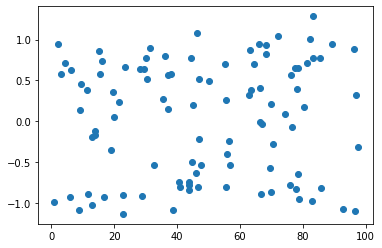

In [3]:
plt.scatter(t, y)

Fit with Lomb-Scargle Method

In [4]:
frequency, power = LombScargle(t, y).autopower()

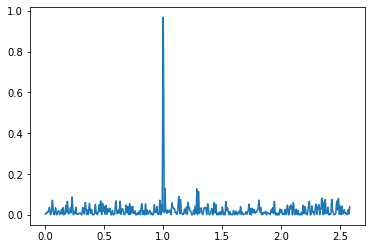

In [5]:
plt.plot(frequency, power)

As expected, there is a peak at a frequency of 1 cycle per unit time.

### Sample Time Series

Text(0, 0.5, 'Flux (mJy)')

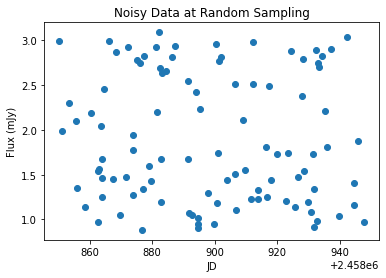

In [6]:
rand2 = np.random.default_rng(10)
t2 = 100 * rand2.random(100) + 2458849
y2 = np.sin(2 * np.pi * t2) + 0.1 * rand2.standard_normal(100) + 2
times = Time(t2, format='jd')
plt.scatter(t2, y2)
plt.title('Noisy Data at Random Sampling')
plt.xlabel('JD')
plt.ylabel('Flux (mJy)')

In [7]:
ts = TimeSeries(time = times, data={'flux': y2 * u.mJy})

Text(0, 0.5, 'Power')

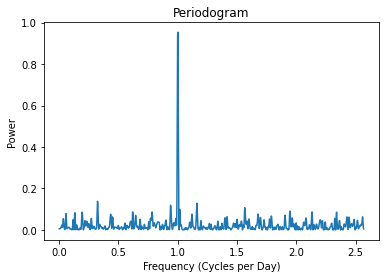

In [8]:
frequency2, power2 = LombScargle(t2*u.day, y2*u.mJy).autopower()
best_freq2 = frequency2[np.argmax(power2)]
plt.plot(frequency2, power2)
plt.title('Periodogram')
plt.xlabel('Frequency (Cycles per Day)')
plt.ylabel('Power')

In [9]:
ts_folded = ts.fold(period=1./best_freq2)

Text(0, 0.5, 'Flux (mJy)')

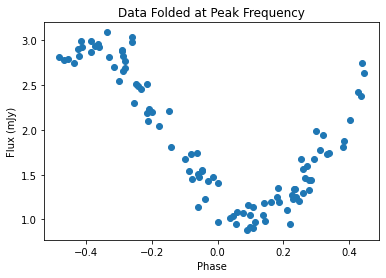

In [10]:
plt.scatter(ts_folded['time'].jd, ts_folded['flux'])
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Flux (mJy)')

## Gaia Light Curve Analysis

In [11]:
from astroquery.gaia import Gaia
from astropy.table import Table, QTable

Get Light Curve from Gaia

In [12]:
query = f"SELECT vari.* \
FROM gaiadr3.vari_summary as vari \
WHERE source_id = '376526416902123392'" # short-timescale variable star

job     = Gaia.launch_job_async(query, output_format='fits')
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 1


<Table length=1>
   solution_id         source_id      num_selected_g_fov mean_obs_time_g_fov time_duration_g_fov ... in_vari_ms_oscillator in_vari_agn in_vari_microlensing in_vari_compact_companion
                                                                  d                   d          ...                                                                                 
      int64              int64              int16              float64             float32       ...          bool             bool            bool                    bool          
------------------ ------------------ ------------------ ------------------- ------------------- ... --------------------- ----------- -------------------- -------------------------
375316653866487564 376526416902123392                 46  2290.9462597207066           1003.2978 ...                 False       False                False                     False

In [14]:
retrieval_type = 'EPOCH_PHOTOMETRY'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink  = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, format='votable', output_file=None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')


The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 376526416902123392.xml


In [15]:
product     = datalink[dl_keys[0]][0]
product_tb  = product.to_table()                  # Export to Astropy Table object.
source_ids  = list(set(product_tb['source_id']))  # Detect source_ids.
print(f' There is data for the following Source ID:')
for source_id in source_ids:
    print(f'* {source_id}')

 There is data for the following Source ID:
* 376526416902123392


#### Light Curve Analysis

In [16]:
gaia_t, gaia_f, gaia_m = product_tb['time'], product_tb['flux'], product_tb['mag']
gaia_g, gaia_r, gaia_b = product_tb['band']=='G', product_tb['band']=='RP', product_tb['band']=='BP'
gaia_gmed, gaia_rmed, gaia_bmed = np.nanmedian(gaia_m[gaia_g]), np.nanmedian(gaia_m[gaia_r]), np.nanmedian(gaia_m[gaia_b])

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


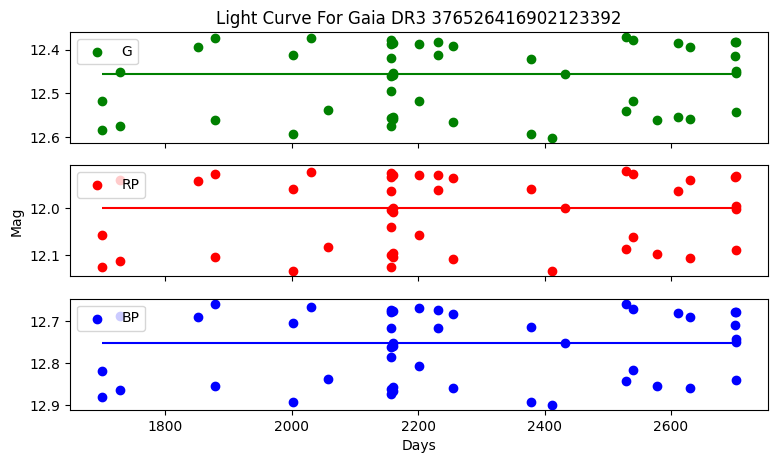

In [27]:
fig, ax = plt.subplots(3, figsize=[9,5], sharex=True, dpi=100)

ax[0].scatter(gaia_t[gaia_g], gaia_m[gaia_g], color='g', label='G')
ax[0].hlines(gaia_gmed, gaia_t[gaia_g][0], gaia_t[gaia_g][-1], color='g')
ax[1].scatter(gaia_t[gaia_r], gaia_m[gaia_r], color='r', label='RP')
ax[1].hlines(gaia_rmed, gaia_t[gaia_r][0], gaia_t[gaia_r][-1], color='r')
ax[2].scatter(gaia_t[gaia_b], gaia_m[gaia_b], color='b', label='BP')
ax[2].hlines(gaia_bmed, gaia_t[gaia_b][0], gaia_t[gaia_b][-1], color='b')


ax[0].set_title(f'Light Curve For Gaia DR3 {source_ids[0]}')
ax[2].set_xlabel('Days')
ax[1].set_ylabel('Mag')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')

In [34]:
gaia_gtime, gaia_rtime, gaia_btime = Time(gaia_t[gaia_g] + 2455197.5, format='jd'), Time(gaia_t[gaia_r] + 2455197.5, format='jd'), Time(gaia_t[gaia_b] + 2455197.5, format='jd')
gaia_gflux, gaia_rflux, gaia_bflux = np.array(gaia_f[gaia_g])*u.electron/u.s, np.array(gaia_f[gaia_r])*u.electron/u.s, np.array(gaia_f[gaia_b])*u.electron/u.s
gaia_gmag, gaia_rmag, gaia_bmag = np.array(gaia_m[gaia_g])*u.mag, np.array(gaia_m[gaia_r])*u.mag, np.array(gaia_m[gaia_b])*u.mag

In [35]:
gaia_gts = TimeSeries(time = gaia_gtime, data={'mag' : gaia_gmag})
gaia_rts = TimeSeries(time = gaia_rtime, data={'mag' : gaia_rmag})
gaia_bts = TimeSeries(time = gaia_btime, data={'mag' : gaia_bmag})

Text(0, 0.5, 'Power')

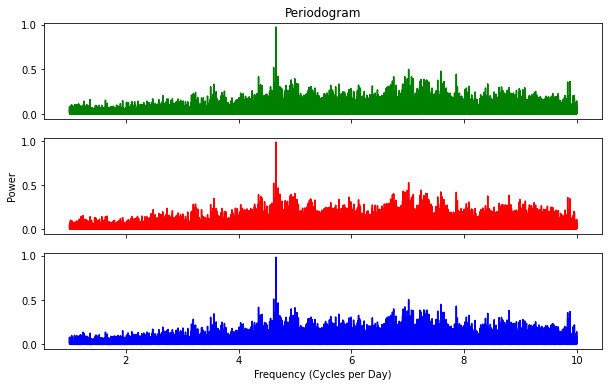

In [37]:
gaia_gfreq, gaia_gpower = LombScargle(gaia_gtime, gaia_gmag.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=10/u.d)
gaia_rfreq, gaia_rpower = LombScargle(gaia_rtime, gaia_rmag.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=10/u.d)
gaia_bfreq, gaia_bpower = LombScargle(gaia_btime, gaia_bmag.value).autopower(minimum_frequency=1/u.d,
                                                   maximum_frequency=10/u.d)

gaia_gbestfreq = gaia_gfreq[np.argmax(gaia_gpower)]
gaia_rbestfreq = gaia_rfreq[np.argmax(gaia_rpower)]
gaia_bbestfreq = gaia_bfreq[np.argmax(gaia_bpower)]

fig, ax = plt.subplots(3, figsize=[10,6], sharex=True)

ax[0].plot(gaia_gfreq, gaia_gpower, color='g')
ax[1].plot(gaia_rfreq, gaia_rpower, color='r')
ax[2].plot(gaia_bfreq, gaia_bpower, color='b')
ax[0].set_title('Periodogram')
ax[2].set_xlabel('Frequency (Cycles per Day)')
ax[1].set_ylabel('Power')

In [38]:
print(1/gaia_gbestfreq)
print(1/gaia_rbestfreq)
print(1/gaia_bbestfreq)

0.21443037768282683 d
0.21443038047747123 d
0.2144303799260479 d


This is the same period found in https://arxiv.org/pdf/2206.05591.pdf (p. 10)

In [39]:
gaia_gts_folded = gaia_gts.fold(period=1./gaia_gbestfreq, normalize_phase=True, epoch_phase=0.25)
gaia_rts_folded = gaia_rts.fold(period=1./gaia_rbestfreq, normalize_phase=True, epoch_phase=0.25)
gaia_bts_folded = gaia_bts.fold(period=1./gaia_bbestfreq, normalize_phase=True, epoch_phase=0.25)

Text(0, 0.5, 'Residual Mag')

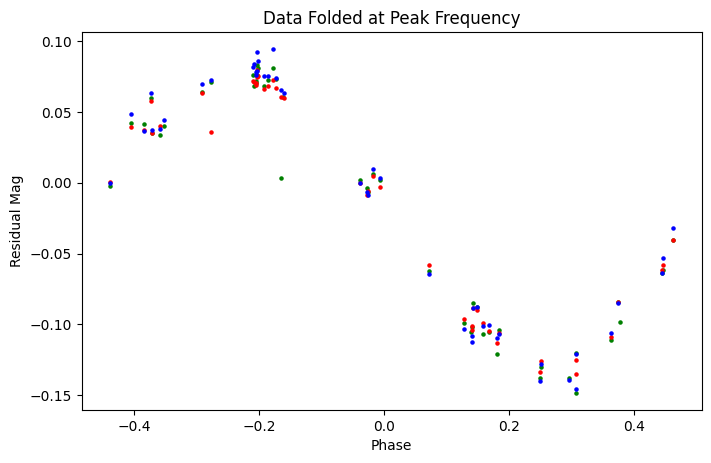

In [47]:
fig = plt.figure(figsize=(8,5), dpi=100)

plt.scatter(gaia_gts_folded['time'], gaia_gmed*u.mag - gaia_gts_folded['mag'], c = 'g', s=5)
plt.scatter(gaia_rts_folded['time'], gaia_rmed*u.mag - gaia_rts_folded['mag'], c = 'r', s=5)
plt.scatter(gaia_bts_folded['time'], gaia_bmed*u.mag - gaia_bts_folded['mag'], c = 'b', s=5)
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Residual Mag')

In [3]:
from scipy.optimize import curve_fit

In [2]:
gaia_gts_folded['time']

NameError: name 'gaia_gts_folded' is not defined